- 环境：
    - window 10
    - visual studio 2019(nmake/cl/link/lib/dumpbin)
    - Qt 5.14.0 (designer/uic/moc)
    - OpenCV 4.2.0
    - Torch C++ 1.5.1
    - cmake
        

- 注意事项：
    1. 编译/链接的环境（编译/链接的命令行设置）：Makefile/CMake/QMake
        1. include
        2. lib
    2. 运行环境：（设置PATH/或者拷贝到当前路径/或者拷贝到window安装目录下的system32）
        1. bin
    3. 动态库也有依赖环境：
        1. window的运行环境（基本上差不多）
        2. vcrt160.lib运行时（visual studio自带/动态库自带）

- lib库名.主版本号.副版本号.批次号.so
- 库名`140.dll/库名160.dll`


# 注意

1. libtorch,opencv, qt的动态库所在路径设置为PATH环境变量
    - 保存编译后的执行文件能调用到动态库；

2. 头文件目录
    - opencv
        - `C:\opencv_new\install\include`
    - qt
        - `C:\Qt\Qt-5.14.0\include`
    - libtorch
        - `C:\libtorch\include`

3. lib
    - 目录
        - `C:\Qt\Qt-5.14.0\lib`
        - `C:\opencv_new\install\x64\vc16\lib`
        - `C:\libtorch\lib`
    - lib文件
        - 根据调用的模块

# CMake

## Qt， OpenCV的例子

- 使用Qt显示一副OpenCV读取的图像

```C++
#include <QtWidgets/QApplication>
#include <QtWidgets/QDialog>
#include <QtWidgets/QLabel>
#include <opencv2/opencv.hpp>


int main(int argc, char **argv){
    // 1. 创建Qt应用
    QApplication app(argc, argv);
    // 2. 创建对话框
    QDialog dlg;
    dlg.setWindowTitle("CMake组织工程");
    dlg.resize(600, 400);
    dlg.move(100, 100);
    // 3. 创建标签狂
    QLabel  lbl("图像显示", &dlg);
    lbl.setGeometry(0, 0, dlg.width(), dlg.height());

    // 4. 打开图像
    cv::Mat img = cv::imread("gpu.bmp");
    cv::cvtColor(img, img, cv::COLOR_BGR2RGB);
    // 5. 显示图像
    QImage qt_img(img.data, img.cols, img.rows, QImage::Format_RGB888);
    QPixmap qt_pixmap = QPixmap::fromImage(qt_img);
    lbl.setPixmap(qt_pixmap);
    lbl.setScaledContents(true);

    dlg.show();
    return app.exec();
}

```

![avartar](1.png)

## CMakeLists.txt

```bash
cmake_minimum_required(VERSION 3.16)

project(main)

# 控制C++编译选项，链接选项
set(CMAKE_CXX_STANDARD 11)
set(CMAKE_CXX_STANDARD_REQIUIRED True)
set(CMAKE_INCLUDE_CURRENT_DIR ON)

# 属于QT专有
set(CMAKE_AUTOMOC ON)
set(CMAKE_AUTOUIC ON)

# 配置Qt的内置的CMake环境（源代码安装才有cmake目录）
set(CMAKE_PREFIX_PATH  "C:/Qt/Qt-5.14.0/lib/cmake")

# Qt的库，头文件自动查找
find_package(Qt5Widgets REQUIRED)
find_package(Qt5Gui REQUIRED)
find_package(Qt5Core REQUIRED)

# 头文件
include_directories(
    C:/Qt/Qt-5.14.0/include
    C:/opencv_new/install/include
)
# 库路径
link_directories(
    C:/opencv_new/install/x64/vc16/lib
    C:/Qt/Qt-5.14.0/lib
)

# 源文件
aux_source_directory(. SOURCES)
add_executable(main ${SOURCES})

# 编译库
target_link_libraries(
    main 
    opencv_core420d.lib
    opencv_imgcodecs420d.lib 
    opencv_imgproc420d.lib 
    Qt5Cored.lib  
    Qt5Widgetsd.lib 
    Qt5Guid.lib
)

```

- 注意：
    - 源代码
    - 头文件
    - lib文件
    - 输出的文件名
    - C++的编译选项/链接选项
    - cmake的封装打包

- Cmake的抽象在于不需要指定具体的编译器
    - 动态侦测，从而实现跨平台安装与部署
    

# Torch C++开发环境与第一个程序

# Torch  C++编程

## Torch C++ 文档

- `https://pytorch.org/cppdocs/api/library_root.html`
    - at命名空间Tensor
    - torch命名：数据集/模型/函数/优化器 

## 数据集

MNIST
Dataset

## 数据集批次处理

DataLoader

## Lenet-5 模型

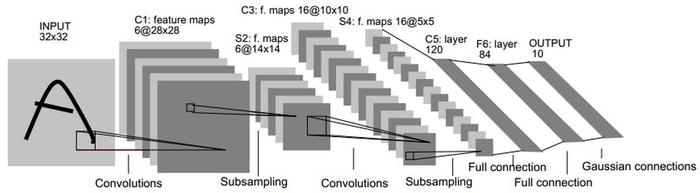

- 作业：
    - 完成文档
        - 运行我们的程序；
        - 理解我们的程序；
    - 可选：
        - 自己独立完成，并理解；

## 训练

``` C++
#include <torch/torch.h>
#include <opencv2/opencv.hpp>

class Lenet5 : public torch::nn::Module{
private:
    // 卷积特征运算
    torch::nn::Conv2d  conv1;
    torch::nn::Conv2d  conv2;
    torch::nn::Conv2d  conv3;
    torch::nn::Linear  fc1;
    torch::nn::Linear  fc2;

public:
    Lenet5():
    conv1(torch::nn::Conv2dOptions(1, 6, 5).stride(1).padding(2)),  // 1 * 28 * 28 -> 6 * 28 * 28 -> 6 * 14 * 14
    conv2(torch::nn::Conv2dOptions(6, 16, 5).stride(1).padding(0)),  // 6 * 14 * 14 -> 16 * 10 * 10 -> 16 * 5 * 5
    conv3(torch::nn::Conv2dOptions(16, 120, 5).stride(1).padding(0)), // 16 * 5 * 5 -> 120 * 1 * 1 (不需要池化)
    fc1(120, 84),  // 120 -> 84
    fc2(84, 10){  // 84 -> 10 (分量最大的小标就是识别的数字)
        // 注册需要学习的矩阵（Kernel Matrix）
        register_module("conv1", conv1);
        register_module("conv2", conv2);
        register_module("conv3", conv3);
        register_module("fc1", fc1);
        register_module("fc2", fc2);
    }

    // override
    torch::Tensor forward(torch::Tensor x){  // {n * 1 * 28 * 28}
        // 1. conv
        x = conv1->forward(x);   // {n * 6 * 28 * 28}
        x = torch::max_pool2d(x, 2);   // {n * 6 * 14 * 14}
        x = torch::relu(x); // 激活函数 // {n * 6 * 14 * 14}
        // 2. conv
        x = conv2->forward(x);   // {n * 16 * 10 * 10}
        x = torch::max_pool2d(x, 2);   // {n * 16 * 5 * 5}
        x = torch::relu(x); // 激活函数 // {n * 16 * 5 * 5}
        // 3. conv
        x = conv3->forward(x);   // {n * 120 * 1 * 1}
        x = torch::relu(x); // 激活函数 // {n * 120 * 1 * 1}
        // 做数据格式转换
        x = x.view({-1, 120});   // {n * 120}
        // 4. fc
        x = fc1->forward(x);
        x = torch::relu(x);
        
        // 5. fc 
        x = fc2->forward(x);
        return  torch::log_softmax(x, 1);   // CrossEntryLoss = log_softmax + nll
    }

};

template <typename  DataLoader> 
void train(std::shared_ptr<Lenet5> &model,  DataLoader &loader,  torch::optim::Adam &optimizer){
    model->train();
    // 迭代数据
    int n = 0;
    for(torch::data::Example<torch::Tensor, torch::Tensor> &batch: loader){
        torch::Tensor data   = batch.data;
        auto target          = batch.target;
        optimizer.zero_grad(); // 清空上一次的梯度
        // 计算预测值
        torch::Tensor y = model->forward(data);
        // 计算误差
        torch::Tensor loss = torch::nll_loss(y, target);
        // 计算梯度: 前馈求导
        loss.backward();
        // 根据梯度更新参数矩阵
        optimizer.step();
        // 为了观察效果，输出损失
        // std::cout << "\t|--批次：" << std::setw(2) << std::setfill(' ')<< ++n 
        //           << ",\t损失值：" << std::setw(8) << std::setprecision(4) << loss.item<float>() << std::endl;
    }

    // 输出误差
}
```

## 验证与测试

```C++
template <typename DataLoader>
void  valid(std::shared_ptr<Lenet5> &model, DataLoader &loader) {
    model->eval();
    // 禁止求导的图跟踪
    torch::NoGradGuard  no_grad;
    // 循环测试集
    double sum_loss = 0.0;
    int32_t num_correct = 0;
    int32_t num_samples = 0;
    for(const torch::data::Example<> &batch: loader){
        // 每个批次预测值
        auto data = batch.data;
        auto target = batch.target;
        num_samples += data.sizes()[0];
        auto y = model->forward(data);
        // 计算纯预测的结果
        auto pred = y.argmax(1);
        // 计算损失值
        sum_loss += torch::nll_loss(y, target, {}, at::Reduction::Sum).item<double>();
        // 比较预测结果与真实的标签值
        num_correct += pred.eq(target).sum().item<int32_t>();
    }
    // 输出正确值
    std::cout << std::setw(8) << std::setprecision(4) 
        << "平均损失值：" << sum_loss / num_samples 
        << ",\t准确率：" << 100.0 * num_correct / num_samples << " %" << std::endl;
}
```

## 模型保存

```C++
std::cout&lt;&lt; "开始训练" &lt;&lt; std::endl;
int epoch = 20;
int interval = 1;   // 从测试间隔
for(int e = 0; e &lt; epoch; e++){
    std::printf("第%02d论训练\n", e+1);
    train(model, *train_loader, optimizer);
    if (e  % interval == 0){
        valid(model, *valid_loader);
    }
}
std:: cout &lt;&lt; "训练结束" &lt;&lt; std::endl;
torch::save(model, "lenet5.pt");
return 0;
```

## 模型加载与识别

```C++
// 训练好的模型文件 // lenet5.pt int main(){ const char * data_filename = ".\data"; // 加载模型 std::shared_ptr model = std::make_shared(); torch::load(model, "lenet5.pt");

// 使用测试集中数据识别
auto imgs = torch::data::datasets::MNIST(data_filename, torch::data::datasets::MNIST::Mode::kTest);
// 取一张图像
for(int i = 0; i &lt; 10; i++){
    torch::data::Example&lt;&gt; example = imgs.get(i);
    // std::cout &lt;&lt; "识别的数字是：" &lt;&lt; example.target.item<int32_t>() &lt;&lt; std::endl;  
    // 获取图像
    torch::Tensor  a_img = example.data;
    // 预测
    a_img = a_img.view({-1, 1, 28, 28});  // 我们的模型只接受4为的固定的数据格式（N * C * H * W）（NCHW格式）
    torch::Tensor  y = model-&gt;forward(a_img);
    int32_t result = y.argmax(1).item<int32_t>();
    std::cout &lt;&lt; "识别的结果是：" &lt;&lt; result &lt;&lt; "-&gt;" &lt;&lt; example.target.item<int32_t>() &lt;&lt;  std::endl;
}
// 使用图像文件来识别
// 读取图像

std::cout &lt;&lt; "----------------------------------" &lt;&lt; std::endl;
cv::Mat im = cv::imread("4.png");
std::cout &lt;&lt; im.size() &lt;&lt; std::endl;
// 转换为Tensor，处理成0-1之间的数字
im.convertTo(im, CV_32FC1, 1.0f / 255.0f);
torch::Tensor  t_img = torch::from_blob(im.data, {28, 28});
t_img = t_img.view({-1, 1, 28, 28});
// std::cerr &lt;&lt; "错误日志" &lt;&lt; std::endl;
// 识别
torch::Tensor  y_ = model-&gt;forward(t_img);
int32_t pred = y_.argmax(1).item<int32_t>();
std::cout &lt;&lt; "识别的结果是：" &lt;&lt; pred &lt;&lt;  std::endl;

return 0;
}
```